# Bayesian Optimization Tutorial

**Module 1: Probabilistic Surrogate Modeling**
*   Instructor: Joel Paulson, Department of Chemical and Biomolecular Engineering, The Ohio State University
*   Date: 04/15/23
*   Location: Great Lakes PSE Student Workshop


# Notebook Overview

This notebook provides an introduction to Gaussian process (GP) modeling in Python, using mostly GPyTorch and BOTorch (which subclasses several modules in GPyTorch). We provide an initial case study to demonstrate the value of GP modeling compared to various alternatives. We then show how to select different kernels, train GP models, handle more complex noise models, and some exercises to try on your own. 

# Install Packages (Setup)

Note all the packages come installed in Google Colab, so run the code below to install external packages.

In [1]:
!pip install gpytorch &> /dev/null
!pip install botorch &> /dev/null
!pip install forestci &> /dev/null # Special toolbox to compute random forest variance

# 1. Statistical Surrogate Model Comparison

A surrogate model (also known as a metamodel or an emulator) is an approximate representation of an outcome of interest that cannot be easily measured or computed. Typically, surrogate models are constructed using a data-driven approach wherein the inner working of the simulation code is not assumed to be known (or even understood) -- only the input-output behavior is important. 

Since the surrogate model is building an approximation of reality, it is useful/important to construct confidence regions 

1.   Gaussian Process Regression [(GP)](https://link.springer.com/chapter/10.1007/978-3-540-28650-9_4)
2.   eXtreme Gradient Boosting [(XGBoost)](https://arxiv.org/pdf/1603.02754.pdf)
3.   Random Forest Modeling [(RF)](https://link.springer.com/article/10.1023/a:1010933404324)
4.   Ensemble Multi-Layer Perceptron [(MLP)](https://www.sciencedirect.com/science/article/abs/pii/0925231291900235)

We will be using [scikit-learn](https://scikit-learn.org/stable/) for each of the above models and look at their performance without getting into the practical details in this section. 


## 1.1 Import Packages and Load Data

We need to import a variety of packages from the sklearn, numpy, pandas, and matplolib packages to train models and plot results. 

In [2]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import forestci as fci
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import optimize
import random
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':18})

# turn off warnings for clean output
import warnings
warnings.filterwarnings('ignore')

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


Next, we need to mount our Google Drive so that we can load data and save results. 

In [3]:
# mount google drive to load data and save results
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Once we have mounted our Google Drive, we need to make sure to navigate to the path that we have saved the file "airfoil_self_noise.csv", which we want to load for this exercise. 

**IMPORTANT: Make sure to change the path name below to match where you have stored the file.**

In [4]:
# change path
%cd '/content/drive/My Drive/Colab Notebooks/CMU_BO_Workshop_2023'

# load data using pandas and print to check part to make sure it worked
df = pd.read_csv('airfoil_self_noise.csv')
print(df.head())

/content/drive/My Drive/Colab Notebooks/CMU_BO_Workshop_2023
   Frequency  Angle of attack  Chord length  Free stream velocity  \
0        800              0.0        0.3048                  71.3   
1       1000              0.0        0.3048                  71.3   
2       1250              0.0        0.3048                  71.3   
3       1600              0.0        0.3048                  71.3   
4       2000              0.0        0.3048                  71.3   

   Suction side displacement  scaled sound pressure  
0                   0.002663                126.201  
1                   0.002663                125.201  
2                   0.002663                125.951  
3                   0.002663                127.591  
4                   0.002663                127.461  


## 1.2 Case Study Description

We will be using the relatively well-known [NASA data set](https://turbmodels.larc.nasa.gov/naca0012_val.html), which is composed of different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. Full dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise).

This problem has the following features/inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels

**Goal: Determine which model exhibits best performance in low data regime**

## 1.3 Generate Results

We run statistical comparisons below to see how well these models fit the data as well as how accurate the confidence bounds are in terms of containing validation data. We use mean absolute error (MAE) to measure performance

$$
\text{MAE} = \frac{1}{N}\sum_{i=1}^N | y_i - \hat{y}_i |
$$

where $y_i$ is the true data point and $\hat{y}_i$ is the prediction. To measure accuracy of the confidence bounds, we count how many test points fall within two standard deviations of the predicted point. We use recommended values for all parameter settings in each of the algorithms. 

Note that the full set of results are shown in the section below. The code below has an option, TEST, that when set to True only runs a small subset of cases (in the interest of time). If you want to generate the full set of results, you will need to set this to false but note that it will take several minutes to complete. For convenience, the full set of results are summarized in the next section. 

In [5]:
# split data for train/test
dataset = df.iloc[:,:].values # normalize [0,1]
train_set, val_set = train_test_split(dataset, test_size= 0.2, train_size = 0.4, random_state=18)
x_train = train_set[:,:-1]
y_train = train_set[:,-1]
x_test  = val_set[:,:-1]
y_test  = val_set[:,-1]

# TEST (if true only runs a subset of cases with fewer samples)
TEST = True

# Note that this will take a long time to run if you set to false -- but you can use that to generate figures below
if TEST:
  dataset_sizes =[10]
else:
  dataset_sizes =[10,15,20,25,50,70,80,100]

# specify number of replicates
if TEST:
  samples = 5
else:
  samples = 10

# store error for all samples and dataset sizes
gp_err  = np.zeros([samples, len(dataset_sizes)])
rf_err  = np.zeros([samples, len(dataset_sizes)])
mlp_err = np.zeros([samples, len(dataset_sizes)])
xg_err  = np.zeros([samples, len(dataset_sizes)])

# store how many validation points caught in confidence regions
gp_catch  = np.zeros([samples, len(dataset_sizes)])
rf_catch  = np.zeros([samples, len(dataset_sizes)])
mlp_catch = np.zeros([samples, len(dataset_sizes)])
xg_catch  = np.zeros([samples, len(dataset_sizes)])

# set max number of training samples and initial index list
nmax = x_train.shape[0]
idxlist = np.arange(nmax)

# loop over number of samples
for k in range(samples):

  # loop over number of dataset sizes
  for j, dss in enumerate(dataset_sizes):
    #take a random set of data 
    samp_idx = random.choices(idxlist, k=dss)

    #define taining sets
    x = x_train[samp_idx,:]
    y = y_train[samp_idx]
    
    # train GP
    gp = GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=0.5), alpha =1e-2, normalize_y=True,).fit(x,y.reshape(-1,1))
    gp_pred, gp_var = gp.predict(x_test, return_std=True)

    # train RF
    rf = RandomForestRegressor(n_estimators = 1750, max_features = 'sqrt', max_depth = 17).fit(x, y)
    rf_pred = rf.predict(x_test)
    rf_var = fci.random_forest_error(rf, x,x_test)

    # train ensemble MLP
    ensemble = 25
    mlp = [MLPRegressor(random_state=i, max_iter=500).fit(x, y) for i in range(ensemble)]
    mlp_preds = np.array([mlp[i].predict(x_test) for i in range(ensemble)])
    mlp_pred = mlp_preds.mean(axis=0)
    mlp_std = mlp_preds.std(axis=0) 

    # train Xgboost
    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
    }
    def get_xg_std(xg, x_test):
      xg_std = []
      for i in range(len(xg.estimators_)):
        xg_std.append(xg.estimators_[i][0].predict(x_test))
      return np.array(xg_std).std(axis=0)
    xg = GradientBoostingRegressor(**params)
    xg.fit(x, y)
    xg_pred = xg.predict(x_test)
    xg_std = get_xg_std(xg,x_test)

    # calculate mean absolute error
    rf_err[k,j] = np.abs(y_test- rf_pred).mean()
    gp_err[k,j] = np.abs(y_test- gp_pred.flatten()).mean()
    mlp_err[k,j] = np.abs(y_test- mlp_pred).mean()
    xg_err[k,j] = np.abs(y_test- xg_pred).mean()

    # count how many points fall within confidence bounds
    rfcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= rf_pred[i]+2*rf_var[i] and y_test[i]>= rf_pred[i]-2*(rf_var[i]):
        rfcount+=1
    gpcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= gp_pred[i]+2*gp_var[i] and y_test[i]>= gp_pred[i]-2*gp_var[i]:
        gpcount+=1
    mlpcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= mlp_pred[i]+2*mlp_std[i] and y_test[i]>= mlp_pred[i]-2*mlp_std[i]:
        mlpcount+=1
    xgcount = 0
    for i in range(len(y_test)):
      if y_test[i]<= xg_pred[i]+2*xg_std[i] and y_test[i]>= xg_pred[i]-2*xg_std[i]:
        xgcount+=1
    rf_catch[k,j] = rfcount/len(y_test)
    gp_catch[k,j] = gpcount/len(y_test)
    mlp_catch[k,j] = mlpcount/len(y_test)
    xg_catch[k,j] = xgcount/len(y_test)

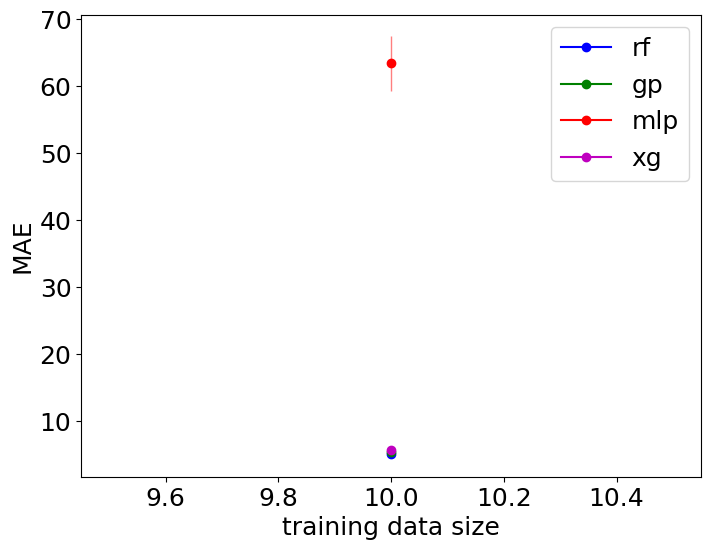

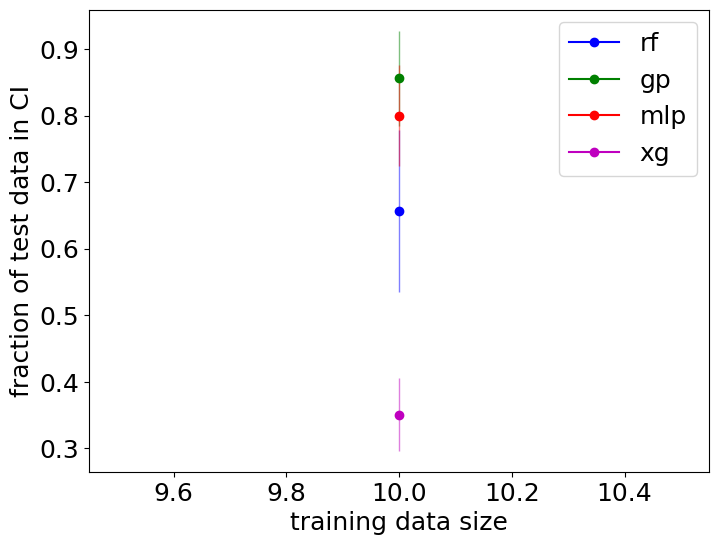

In [6]:
# create MAE plot
colors = ['b', 'g', 'r', 'm']
labels = ['rf', 'gp', 'mlp', 'xg']
model_err = [rf_err, gp_err, mlp_err, xg_err]
plt.figure(figsize=(8,6))
for (i,err) in enumerate(model_err):
  axes = plt.plot(dataset_sizes,  err.mean(axis=0), marker ='o' , color = colors[i], label=labels[i],)
  plt.fill_between(dataset_sizes, err.mean(axis=0)+err.std(axis=0), err.mean(axis=0)-err.std(axis=0), color=colors[i], alpha=0.5)
plt.xlabel('training data size')
plt.ylabel('MAE')
plt.legend();

# create confidence bound fraction plot
model_catch = [rf_catch, gp_catch, mlp_catch, xg_catch]
plt.figure(figsize=(8,6))
for (i,catch) in enumerate(model_catch):
  axes = plt.plot(dataset_sizes,  catch.mean(axis=0), marker ='o' , color = colors[i], label=labels[i],)
  plt.fill_between(dataset_sizes, catch.mean(axis=0)+catch.std(axis=0), catch.mean(axis=0)-catch.std(axis=0), color=colors[i], alpha=0.5)
plt.xlabel('training data size')
plt.ylabel('fraction of test data in CI')
plt.legend();

## 1.4 Result Summary

The full set of results are shown in the figures below. We can clearly see that the GP has good MAE, though it is beaten out as the amount of data increases by RF and XGBoost. However, we see a major difference when it comes to the fraction of data captured by the confidence intervals. Clearly, GP models are significantly better at provided accurate bounds on its future predictions, which plays an important role in decision-making, as we will see in later modules. 

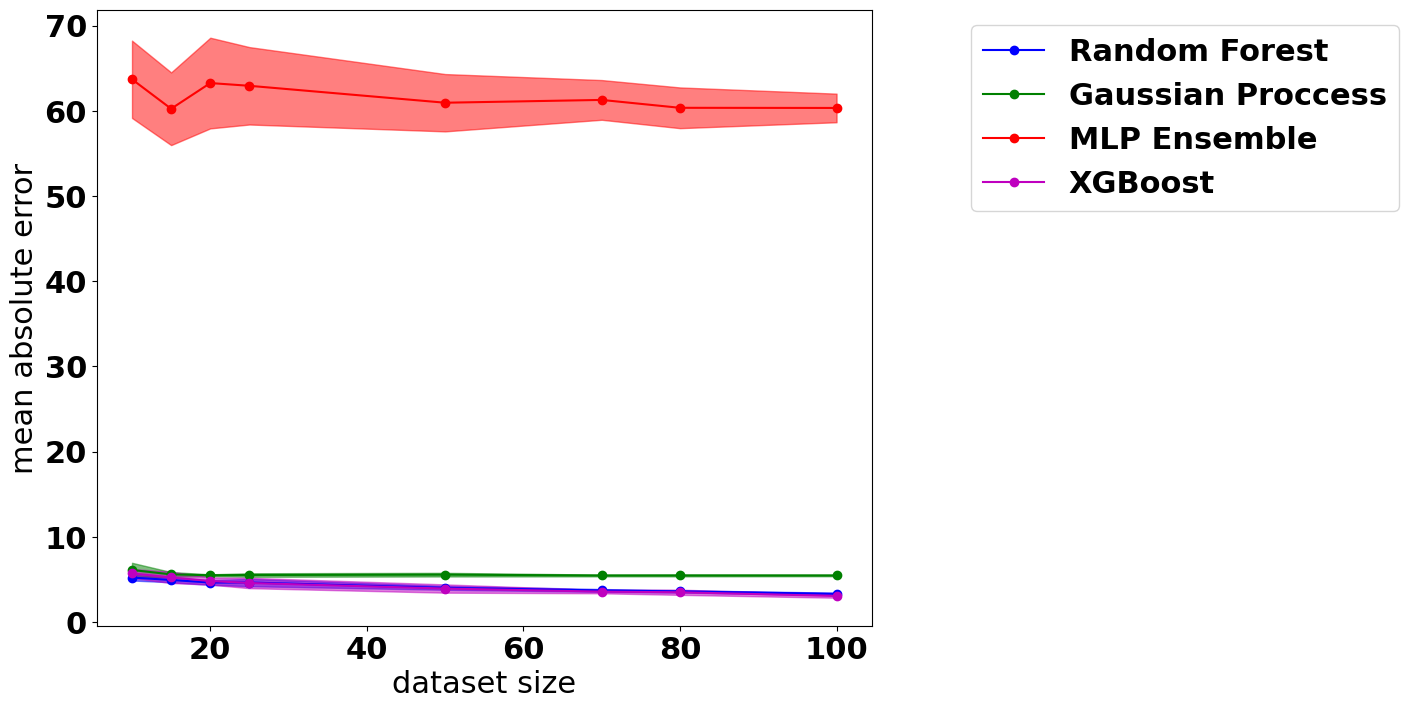

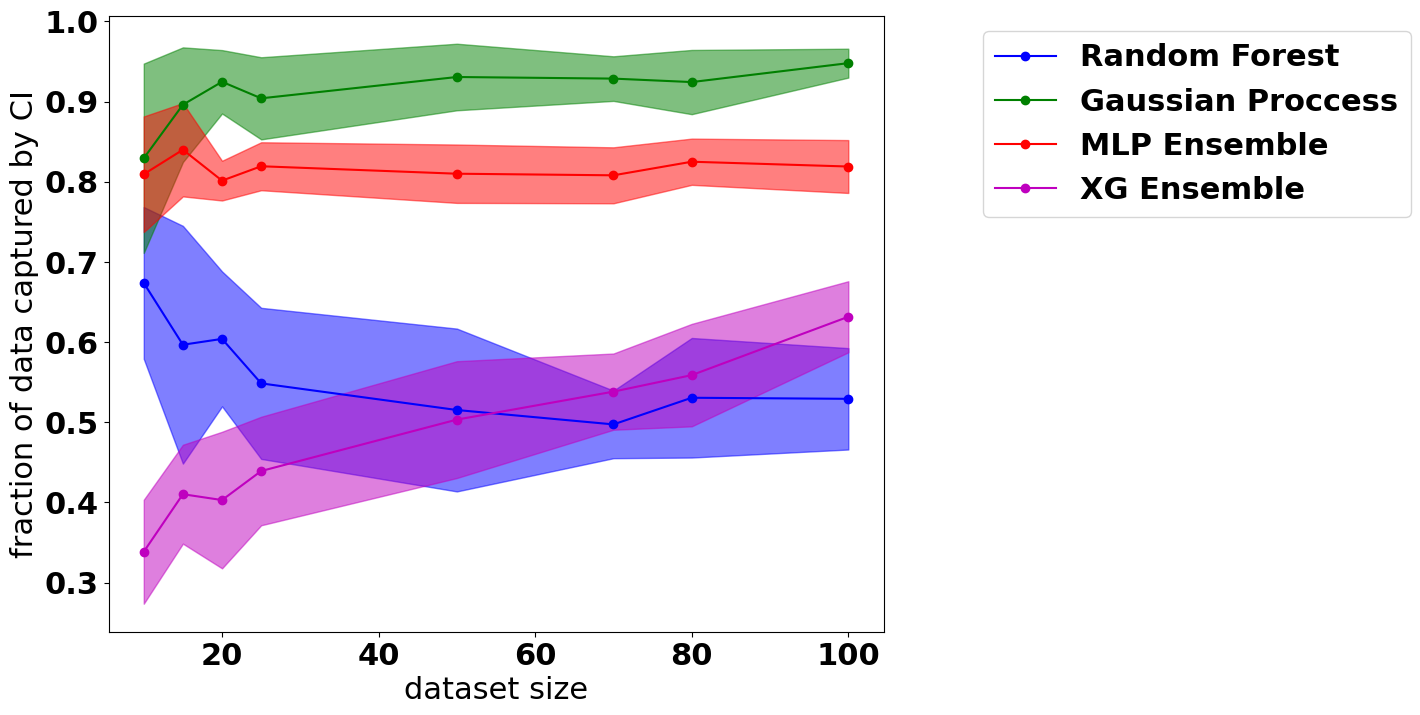

# 2. Working with Kernels

The [GPyTorch](https://gpytorch.ai/) package has several built-in kernel functions $k : \Omega \times \Omega \to \mathbb{R}$, which is a key function that makes up the prior in a Gaussian process model (the mean function is often set to 0, justified by scaling the outputs). The kernel $k(x,x')$ defines how much the target function is expected to be correlated at two points $x$ and $x'$. It is important to know how to construct and work with kernels before working with GPs. 

## 2.1 Import Packages

We need to use a variety of torch, gpytorch, and botorch packages in this section, so we pre-load them below.

In [7]:
import torch
import math
import torch
import gpytorch
import botorch
import matplotlib.pyplot as plt
import numpy as np
from botorch.fit import fit_gpytorch_model
import matplotlib
from matplotlib import cm
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel, PeriodicKernel
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP, HeteroskedasticSingleTaskGP
from botorch.optim import optimize_acqf

## 2.2 Play with Kernel and Hyperparameters

Below is a simple set of code that plots the squared exponential (also known as radial basis function (RBF)) kernel for different hyperparameters for a 1d function (note that we plot $x$ versus $x'$ below, which is why there are two separate dimensions).

Two short exercises:

1. Replace with RBFKernel with a Matern $\nu=0.5$ kernel, which you can find on this [page of kernels](https://docs.gpytorch.ai/en/latest/kernels.html). 

  * Does this show more or less correlation than an RBFKernel?

2. Incorporate an outer scale kernel, which can also be found on the kernel page above, and set the output scale parameter to 50.

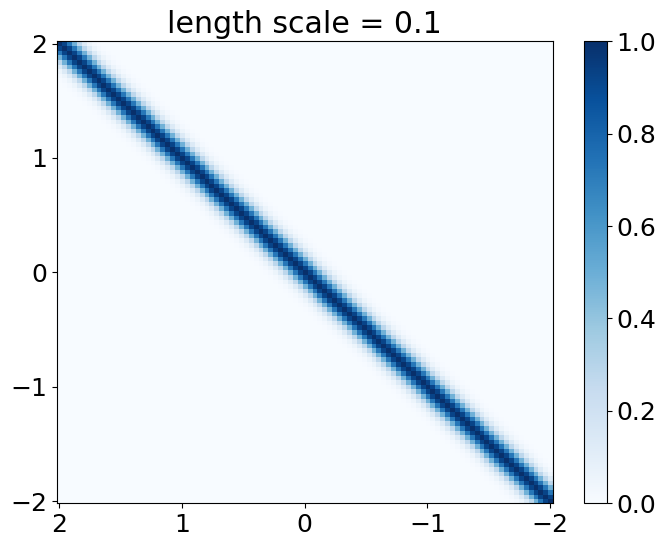

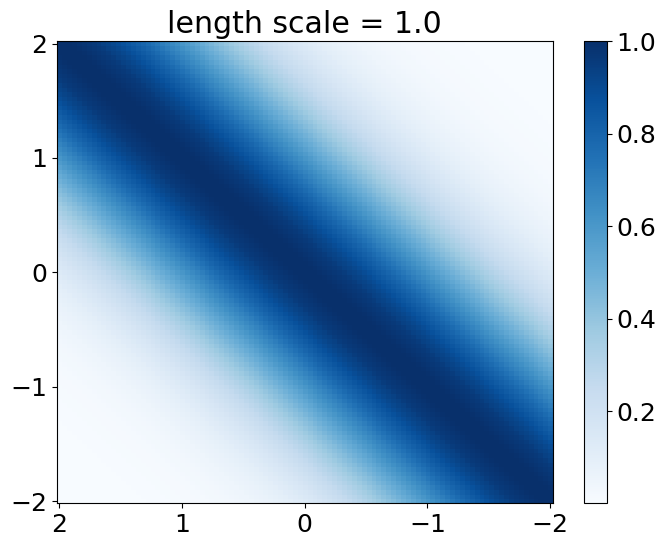

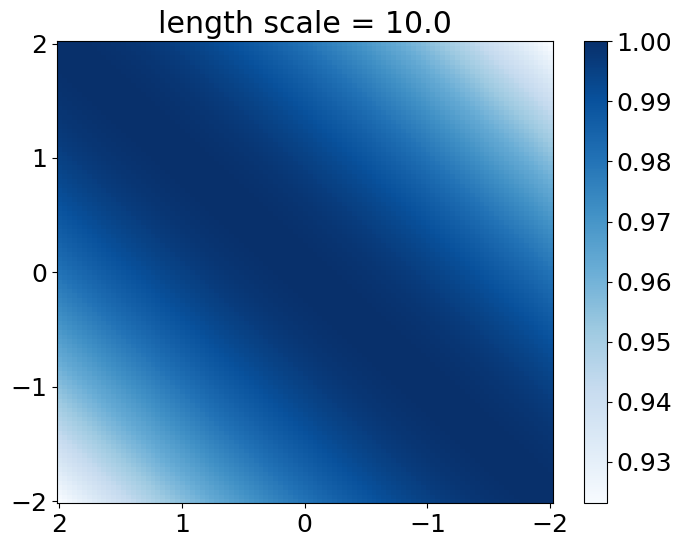

In [8]:
# import type of kernel 
##############    # import some additional kernels
from gpytorch.kernels import RBFKernel
##############

# define simple covariance function in 1d
##############    # try to use a different type of covariance here
covar = RBFKernel(ard_num_dims=1)
##############

# list of lengthscales
len_scales = [0.1, 1.0, 10.0]

# loop over lengthscales
for len_scale in len_scales:
  # set lengthscale
  covar.lengthscale = len_scale

  # create a grid of points in 1d
  x = torch.linspace(-2, 2, 101)

  # create a meshgrid for plotting purposes
  X, Y = torch.meshgrid([x, x])

  # evaluate covariance function between all elements of x
  with torch.no_grad():
    K = covar(x, x)
  K = K.detach().numpy()

  # plot covariance between x vector
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  c = ax.pcolor(X, Y, K, cmap=cm.Blues)
  ax.set_yticks(np.linspace(-2,2,5))
  ax.invert_xaxis()
  ax.set_xticks(np.flip(np.linspace(-2,2,5)))
  ax.set_title(f'length scale = {len_scale}')
  fig.colorbar(c, ax=ax);    

## 2.3 Exercise: Generate Random Samples from GP

Now that we have the ability to evaluate kernels, we actually have the capacity to generate random samples from a GP. Recall from the Module 1 slides that we can apply the whitening transformation to find:

$$
\mathbf{f} \sim \mathcal{N}(\mathbf{m}, \mathbf{K}) 
$$

is equivalent to

$$
\mathbf{f} = \mathbf{m} + \mathbf{L} \mathbf{Z}
$$

where $\mathbf{L}$ is the Cholesky decomposition of $\mathbf{K} = \mathbf{L}\mathbf{L}^\top$ and $\mathbf{Z} \sim \mathcal{N}(0,I)$. 

Use this idea to generate 3 random samples between -1 and 1 from a GP with zero mean and an RBF Kernel with length scales equal to 1. Note that you can use the [```torch.linalg.cholesky```](https://pytorch.org/docs/stable/generated/torch.linalg.cholesky.html) and [```torch.randn```](https://pytorch.org/docs/stable/generated/torch.randn.html) to compute the Cholesky decomposition and generate standard normal random variables in torch, respectively. The answer is provided below, but please only look at it after you have tried the exercise.

In [9]:
# Exercise result here


Answer:

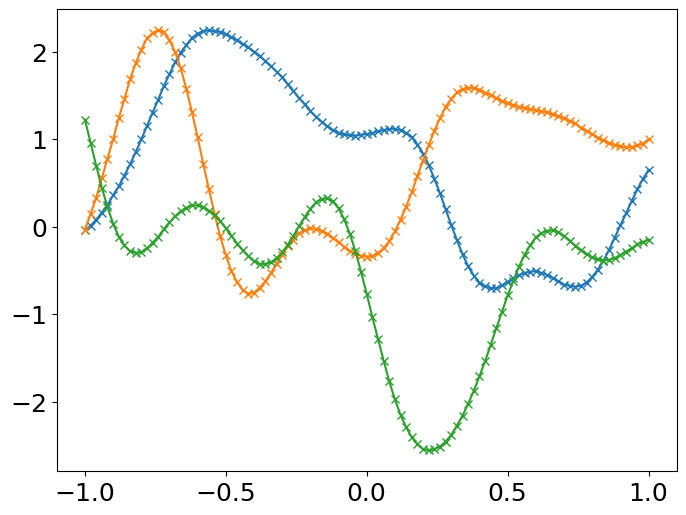

In [18]:
#@title
# Answer to exercise
covar = RBFKernel(ard_num_dims=1)
covar.lengthscale = 0.2
n = 101
x = torch.linspace(-1,1,n)
with torch.no_grad():
  K = covar(x, x)
L = torch.linalg.cholesky(K)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(3):
  f = torch.matmul(L, torch.randn((n,1)))
  plt.plot(x.detach().numpy(), f.detach().numpy(), '-x')

# 3. Gaussian Process Regression

Recall that, given a prior GP distribution $f \sim \mathcal{GP}(\mu_0, k_0)$, we can construct the posterior distribution given all available data $x_{1:n}, y_{1:n}$, which must remain a GP with the following mean and variance functions (assuming $\mu_0 = 0$):

$$
\mu_n(x) = k_0(x,x_{1:n}) \left( k_0(x_{1:n}, x_{1:n}) + \sigma^2 I_n \right)^{-1} y_{1:n}
$$

$$
\sigma_n^2(x) = k_0(x,x) - k_0(x,x_{1:n}) \left( k_0(x_{1:n}, x_{1:n}) + \sigma^2 I_n \right)^{-1} k_0(x_{1:n}, x)
$$

Since the kernel $k_0$ often depends on several hyperparameters, we need some systematic way to select them. We use the maximum likelihood estimation method, as summarized in the Module 1 material. See Page 19 of [Rasmussen & Williams](https://gaussianprocess.org/gpml/chapters/RW.pdf) for more details. 

## 3.1 Get Trained GP Function

In the following code block, we have implemented a simple "helper function" that will allow you to effectively train the hyperparameters of a GP model under various settings. In particular, you can directly feed the name of the kernel in as a string as well as specify if the observations are noisy or not. There are also some options for plotting 1d functions.

In [11]:
# Helper function that takes input data, kernel+likelihood specifications, and plotting options --> return trained model
def get_trained_GP(X, Y, kernel_type, noise_free=False, plot_1d=False, plot_bounds=None):
    """
    This function is used to train a GP model based on the type of kernel that you select.
    This function will be used in modules 1,2,and 3. Save this function for later
    If you delete this cell accidentally, let us know!

    -----------
    Arg:
    X: Features/ Input vector -- torch tensor 
    Y: Mapping/ Target variable vector -- torch tensor
    kernel_type: 'RBF'/'Linear'/'Periodic'/'Matern05'/'Matern15'/'Matern25' select one -- str
    noise_free: True or False (are observations noise free?)
    plot_1d: True or False (should we plot or not?)
    plot_bounds: Tuple of lower and upper bounds (xL, xU)

    ----------
    returns:

    model: a GP model object in train mode -- gpytorch
    """  

    # make sure input data is shaped properly (ntrain by ninputs)
    if X.ndim < 2:
      print("Need to specify as matrix of size ntrain by ninputs")

    # make sure training data has the right dimension
    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)

    # output scaling
    standardize = Standardize(m=Y.shape[-1])
    outcome_transform = standardize

    # select covariance module
    input_dim = X.shape[-1]
    if kernel_type == 'RBF':
        covar_module = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Linear':
        covar_module = ScaleKernel(LinearKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Periodic':
        covar_module = ScaleKernel(PeriodicKernel(ard_num_dims=input_dim))
    elif kernel_type == 'Matern05':
        covar_module = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern15':
        covar_module = ScaleKernel(MaternKernel(nu=1.5, ard_num_dims=input_dim))
    elif kernel_type == 'Matern25':
        covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=input_dim))

    # set the likelihood
    if noise_free:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=1e-3))
    else:
      likelihood = GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-5, upper_bound=100))

    # define the model
    model = SingleTaskGP(train_X=X, train_Y=Y, covar_module=covar_module, likelihood=likelihood, outcome_transform=outcome_transform)

    # call the training procedure
    model.outcome_transform.eval()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # put in eval mode
    model.eval()

    # plot if specified 
    if plot_1d:
      if input_dim == 1:
        if plot_bounds is None:
          print("Plot bounds not specified!")
        else:
          x_list = torch.linspace(plot_bounds[0], plot_bounds[1], 101)
          preds = model.posterior(x_list.unsqueeze(-1))
          mean = preds.mean.squeeze()
          var = preds.variance.squeeze()
          lcb = mean - 2*torch.sqrt(var)
          ucb = mean + 2*torch.sqrt(var)
          plt.figure(figsize=(8,6))
          plt.plot(x_list, mean.detach().numpy())
          plt.fill_between(x_list, lcb.detach().numpy(), ucb.detach().numpy(), alpha=0.2)
          plt.scatter(X.detach().numpy(), Y.detach().numpy(), color ='red', marker ='*')
          plt.xlabel('input')
          plt.ylabel('target')
      else:
        print("Too many input dimensions to plot!")

    # return the trained model
    return model

Let's try this function out on a simple problem, just to make sure that things are working okay.

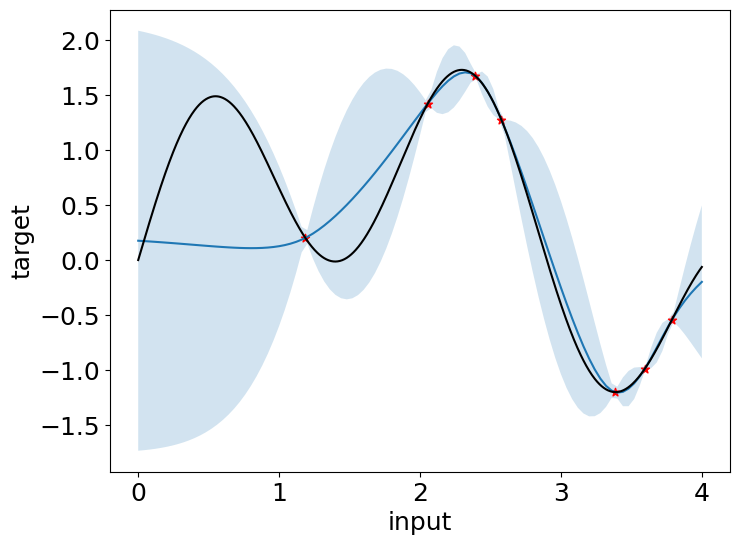

In [12]:
# write a simple 1d function [feel free to modify]
f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

# define input range
x_min, x_max = 0, 4

# generate some number of random data points
Ninit = 7
torch.manual_seed(8)
x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
y_train = f(x_train)

# fit model
model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=True, plot_1d=True, plot_bounds=(x_min, x_max))
xlist = torch.linspace(x_min, x_max, 1001)
plt.plot(xlist, f(xlist), '-k');

## 3.2 Noisy Observations

Let us see how well the GP model works in the presence of a noticable amount of noise.

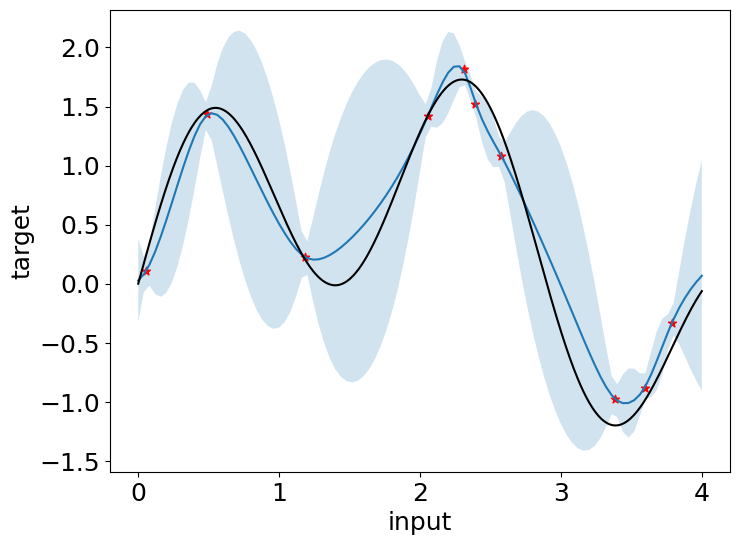

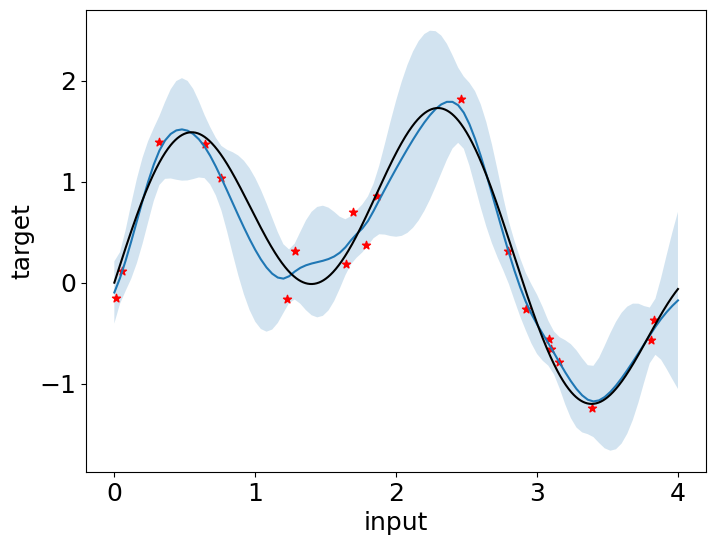

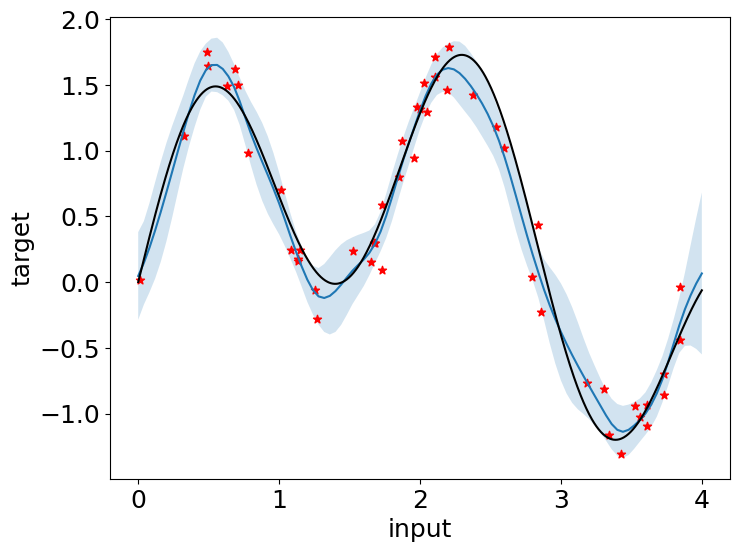

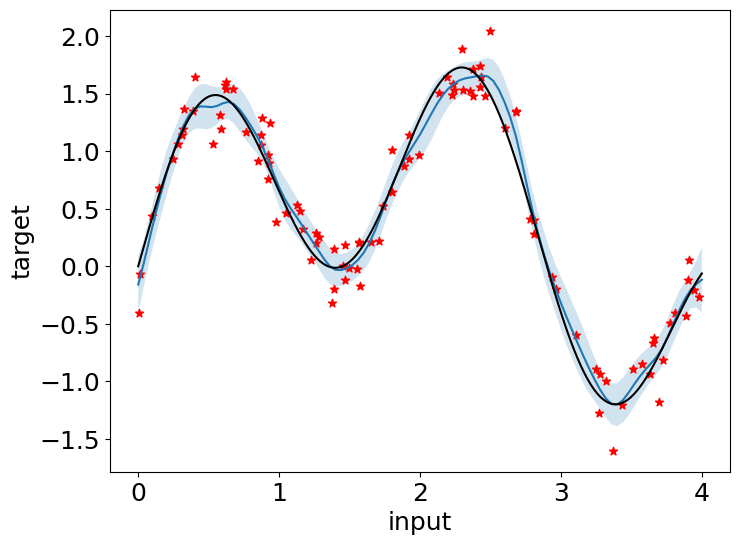

In [13]:
# write a simple 1d function [feel free to modify]
f = lambda x: torch.sin(x) + torch.sin((10.0 / 3.0) * x)

# define input range
x_min, x_max = 0, 4

# list of Ninit values
Ninit_list = [10, 20, 50, 100]

# noise standard devation
noise_std = 0.2

# fix random seed 
torch.manual_seed(8)

# loop over Ninit
for Ninit in Ninit_list:
  # generate some number of random data points
  x_train = (x_max-x_min)*torch.rand((Ninit,1)) + x_min
  eps_train = noise_std*torch.randn((Ninit,1))
  y_train = f(x_train) + eps_train

  # fit model
  model = get_trained_GP(x_train, y_train, 'Matern15', noise_free=False, plot_1d=True, plot_bounds=(x_min, x_max))
  xlist = torch.linspace(x_min, x_max, 1001)
  plt.plot(xlist, f(xlist), '-k');

# 4. More Advanced Features

There are several advanced modeling features that have been developed and implemented in GPyTorch -- new development is happening all of the time, so its good to keep look into the package in more detail after the workshop. Two are discussed below in a little more detail, with one additional code example being provided (shows how to build input-dependent or heteroscedastic GPs).

## 4.1 Heteroscedastic GPs

GPs can handle some degree of noise/uncertainty in the training data assuming its behavior is roughly Gaussian with constant variance for all inputs. This is referred to as homoscedastic or input-independant noise. In most real world systems however, this assumption does not hold and they can more generally have input-dependant or heteroscedastic noise. As an exmaple, imagine a rocket traveling into space and you are trying to measure its position relative to time. Initially your measurements will be fairly confident since the rocket has not traveled very far yet and has not reached its maximum speed yet. As time goes on, the uncertainty will increase as the weight of the fuel consumed, atmospheric effects, and distance from the object begin to change. A normal Gaussian process would attribute the early and ending behavior the same level of uncertainty. This can impact the efficiency of Bayesian optimization and lead to worse decision making due to the reduced model accuracy.

One method for combatting this is the use of heteroscedastic Gaussian processes (HGPs). These HGPs use other methods for predicting the noise levels in the model than traditional GPs which commonly treat noise as another hyperparameter to optimize. One of the most common methods is break the model down into two seperate GPs, with one measuring function outputs and the other measuring the noise level. Many different types of models have been proposed and a short list of more popular methods are provided below.

#### MCMC HGP
The first HGP developed was developed by Goldberg et al. (1998). They broke down the HGP into two seperate GPs with one predicting the function output and the other predicting noise. In order to model the noise prediction, they used Markov Chain Monte Carlo (MCMC) to obtain estimates of the noise function. Although this allowed for successfully modeling the noisy data, it was computationally slow and resource intensive.
* Paper Link: [MCMC HGP](http://www.cs.ox.ac.uk/people/paul.goldberg/papers/gwb-nips97.pdf)

### Most Likely HGP
One of the next methods developed was the Most Likely HGP (MLHGP) by Kersting et al. (2007). The MLHGP implemented an interative approach to creating the model. The variance of the function output GP is used as the training data for the noise GP. These GPs are then combined to form the HGP. This process is then iterated over until convergence. One issue with this mesthod is that convergence is not well defined and some convergence issues occur where the process can infinitely oscillate towards a solution but never find one.

* Paper Link: [MLHGP](https://people.csail.mit.edu/kersting/papers/kersting07icml_mlHetGP.pdf)

### Improved Most Likely HGP
Looking to improve upon the MLHGP, the Improved MLHGP (IMLHGP) or Residual HGP (RHGP) was developed by Zhang and Ni (2020). This model removed the iteration requirement from the MLHGP and simplified the noise modeling process. The function output GP is used to calculate the residuals between the mean prediction and the known data points. These residuals are then used to make noise predictions at these locations using a noise handling GP. The noise levels are then updated using a scaling factor and predictions can be made. This methed is very simple and easy to implement but runs into stability issues. 

* Paper Link: [RHGP](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9103623)

### Variational HGP
Another noise modeling attempt was the Variational HGP (VHGP) developed by L´azaro-Gredilla and Titsias (2011). This method used variational methods and KL divergence from information theory to seperate the output prediction and noise prediction into seperate functions which could be modeled using Guassian processes. A lower bound on the prior was also constructed to ensure the variational models are as accurate as possible. These models are then combined and Guassian quadrature is used to make the posterior predictions. This method is one of the most accruate and computationally efficent methods developed and does not suffer from convergence or stability issues. 

* Paper Link: [VHGP](https://icml.cc/2011/papers/456_icmlpaper.pdf)

Below we are going to compare the standard GP and Heteroscedastic GP (HGP) modeling capabilities for the following synthetic dataset.

$ f(x) = 2sin(2\pi x) $ 

$ g(x) = x + 0.5 $ 

$ x \in [0,1] $ 

We start by defining the model and the training data.

In [14]:
# Define model functions
def f(x):
    f = 2*np.sin(2*np.pi*x)
    return f

def g(x):
    g = x + 0.5
    return g

def data_gen(x):
    fval = f(x)
    gval = g(x)
    Z = np.random.randn(np.shape(x)[0])
    y = fval + Z*gval
    return y

# Define model parameters
np.random.seed(7)
xL = 0
xU = 1
x_plot = np.linspace(xL,xU,1000)

# Create mean and confdence bounds
mean_true = f(x_plot)
conf_upper = f(x_plot) + g(x_plot)
conf_lower = f(x_plot) - g(x_plot)

# Generate some data
n_train = 20
x_train = np.random.rand(n_train)
y_train = data_gen(x_train)

Now we will simply plot the data 

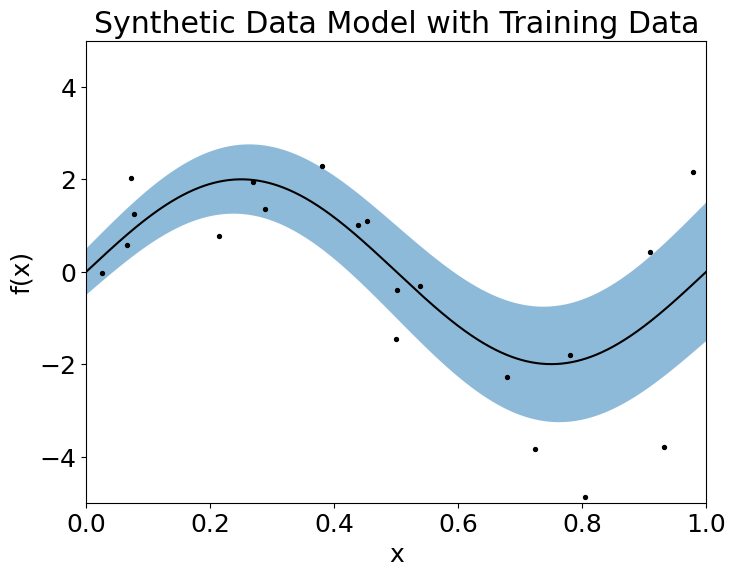

In [15]:
# Plot mean and confidence bounds
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(x_plot,mean_true, 'k')
ax.fill_between(x_plot,conf_upper,conf_lower, alpha = 0.5)
ax.scatter(x_train,y_train, 8, 'k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Synthetic Data Model with Training Data')
ax.set_xlim(0,1)
ax.set_ylim(-5,5);

We can now fit a standard GP model to the data with a constant variance noise term. 

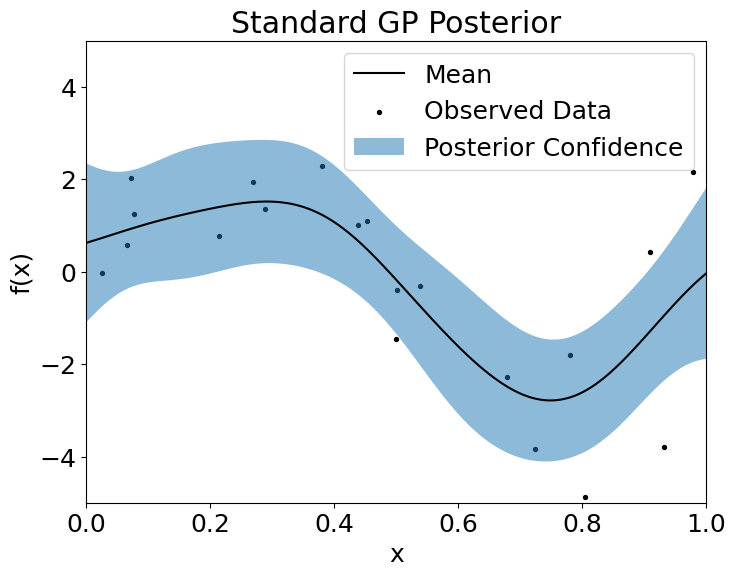

In [16]:
# Construct the GP Model (Input-Independent Noise Variance)

# Transform data to torch
plot_X = torch.from_numpy(x_plot)
train_X = torch.from_numpy(x_train).unsqueeze(-1)
train_Y = torch.from_numpy(y_train).unsqueeze(-1)

# Begin with standard GP
model = SingleTaskGP(train_X, train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

# Extract GP posterior for plotting
with torch.no_grad():
    posterior = model.posterior(plot_X)
    mean_GP = posterior.mean
    stdev_GP = posterior.variance
    lower_GP, upper_GP = posterior.mvn.confidence_region()

    fig, ax = plt.subplots(1,1,figsize = (8,6))

    ax.plot(x_plot,mean_GP.numpy(), 'k')
    ax.scatter(x_train,y_train, c='k', s=8)
    ax.fill_between(x_plot,lower_GP.numpy(),upper_GP.numpy(), alpha = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Standard GP Posterior')
    ax.legend(['Mean','Observed Data','Posterior Confidence'])
    ax.set_xlim(xL,xU)
    ax.set_ylim(-5,5)

We can then build a residual HGP model by trying to use the previous model to get a better estimate of the noise at every input point. 

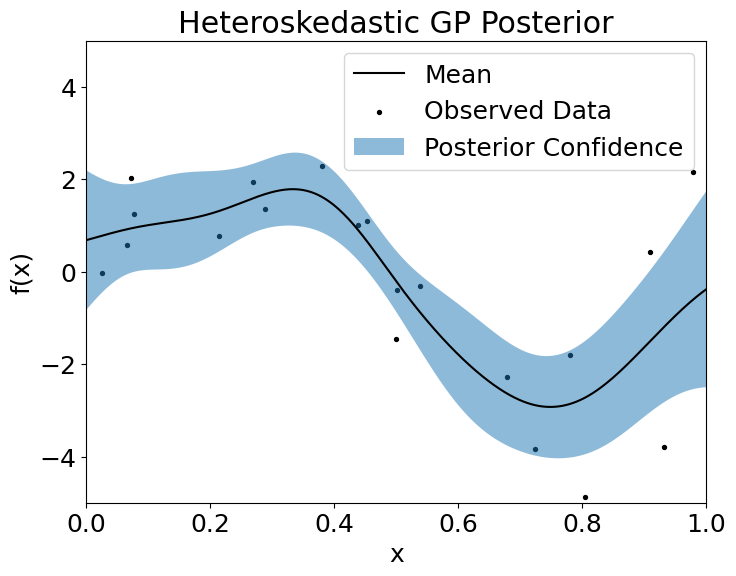

In [17]:
# Construct HGP using RHGP Implementation
residuals = torch.tensor(model.posterior(train_X).mean.detach().numpy() - train_Y.detach().numpy())
nu = 2
z = torch.pow(residuals,2)

model = HeteroskedasticSingleTaskGP(train_X, train_Y, z)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

with torch.no_grad():
    posterior = model.posterior(plot_X)
    mean_HGP = posterior.mean
    stdev_HGP = posterior.variance
    lower_HGP, upper_HGP = posterior.mvn.confidence_region()

    fig, ax = plt.subplots(1,1,figsize = (8,6))

    ax.plot(plot_X,mean_HGP.numpy(), 'k')
    ax.scatter(x_train,y_train, c='k', s=8)
    ax.fill_between(plot_X,lower_HGP.numpy(),upper_HGP.numpy(), alpha = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Heteroskedastic GP Posterior')
    ax.legend(['Mean','Observed Data','Posterior Confidence'])
    ax.set_xlim(xL,xU)
    ax.set_ylim(-5,5)

## 4.2 Combining Kernel Functions

As described earlier, the power of Gaussian processes lies in the choice of the kernel function. This property allows experts to introduce domain knowledge into the process and lends Gaussian processes their flexibility to capture trends in the training data. For example, by choosing a suitable bandwidth for the RBF kernel, we can control how smooth the resulting function will be.

A big benefit that kernels provide is that they can be combined together, resulting in a more specialized kernel. The decision which kernel to use is highly dependent on prior knowledge about the data, e.g. if certain characteristics are expected. Examples for this would be stationary nature, or global trends and patterns. As introduced in the section on kernels, stationary means that a kernel is translation invariant and therefore not dependent on the index i. This also means that we cannot model global trends using a strictly stationary kernel. 

Remember that the covariance matrix of GP has to be positive semi-definite. When choosing the optimal kernel combinations, all methods that preserve this property are allowed. The most common kernel combinations would be addition and multiplication. Check the [gpytorch kernels](https://docs.gpytorch.ai/en/latest/kernels.html) to learn more about implementation details. 

The [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) is also a nice webpage that gives several examples of different ways to build kernels. 